In [13]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
import os
import time
import warnings
import numpy as np
from numpy import newaxis
import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import pyedflib
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy Numpy warnings

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

def load_data(filename):
    g = pyedflib.EdfReader(filename)
    n = g.signals_in_file
    signal_labels = g.getSignalLabels()
    sig = np.zeros((n, g.getNSamples()[0]))
    for i in np.arange(n):
        len_sig = len(g.readSignal(i))
        sig[i, :len_sig] = g.readSignal(i)
    return sig
def make_data(sig, seq_len, normalise_window):
    

    data = sig[0][:500]
    if not normalise_window:
        data = difference(data,1)
    sequence_length = seq_len + 1
    result = np.zeros((len(data) - sequence_length, sequence_length))
    for index in range(len(data) - sequence_length):
        result[index] = data[index: index + sequence_length]
    
    if normalise_window:
        result = normalise_windows(result)
    
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    #np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

In [11]:
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data
        
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_shape=(layers[1], layers[0]),
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    return model



In [18]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

In [ ]:
def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [ ]:
import time
import matplotlib.pyplot as plt

def plot_results(predicted_data, true_data, make_line):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    if make_line:
        plt.axvline(x=y_train.shape[0] + 1, linestyle='--', color = 'b', label = 'future predicted points')
    plt.show()

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

In [ ]:
global_start_time = time.time()
seq_len = 50

print('> Loading data... ')
sig = load_data('sample-data/SC4001E0-PSG.edf')




In [ ]:
X_train, y_train, X_test, y_test = make_data(sig, seq_len, False)


In [19]:
print('> Data Loaded. Compiling...')
epochs  = 450
model = build_model([1, 50, 100, 1])
history = LossHistory()

model.fit(X_train, y_train, batch_size=250, nb_epoch=epochs, validation_split=0.05, callbacks=[history])

#predictions = lstm.predict_sequences_multiple(model, X_test, seq_len, 50)
#predicted = lstm.predict_sequence_full(model, X_test, seq_len)


> Data Loaded. Compiling...
('> Compilation Time : ', 0.010864973068237305)
Train on 382 samples, validate on 21 samples
Epoch 1/450
382/382 [==============================] - 1s 2ms/step - loss: 127.8604 - val_loss: 105.7377
Epoch 2/450
382/382 [==============================] - 0s 619us/step - loss: 125.4630 - val_loss: 99.0716
Epoch 3/450
382/382 [==============================] - 0s 657us/step - loss: 122.6352 - val_loss: 90.1862
Epoch 4/450
382/382 [==============================] - 0s 626us/step - loss: 120.0043 - val_loss: 83.9425
Epoch 5/450
382/382 [==============================] - 0s 655us/step - loss: 116.9900 - val_loss: 74.4598
Epoch 6/450
382/382 [==============================] - 0s 691us/step - loss: 114.4737 - val_loss: 65.0750
Epoch 7/450
382/382 [==============================] - 0s 644us/step - loss: 112.5326 - val_loss: 64.3515
Epoch 8/450
382/382 [==============================] - 0s 622us/step - loss: 112.6072 - val_loss: 55.1635
Epoch 9/450
382/382 [===========

382/382 [==============================] - 0s 677us/step - loss: 84.0852 - val_loss: 57.7472
Epoch 78/450
382/382 [==============================] - 0s 606us/step - loss: 84.1541 - val_loss: 74.9968
Epoch 79/450
382/382 [==============================] - 0s 643us/step - loss: 84.4345 - val_loss: 61.1960
Epoch 80/450
382/382 [==============================] - 0s 643us/step - loss: 82.2215 - val_loss: 60.5988
Epoch 81/450
382/382 [==============================] - 0s 651us/step - loss: 82.8188 - val_loss: 44.2516
Epoch 82/450
382/382 [==============================] - 0s 615us/step - loss: 85.1135 - val_loss: 73.2447
Epoch 83/450
382/382 [==============================] - 0s 608us/step - loss: 83.9513 - val_loss: 49.2949
Epoch 84/450
382/382 [==============================] - 0s 660us/step - loss: 83.0437 - val_loss: 54.2191
Epoch 85/450
382/382 [==============================] - 0s 651us/step - loss: 81.7972 - val_loss: 57.8785
Epoch 86/450
382/382 [==============================] - 0s 

Epoch 154/450
382/382 [==============================] - 0s 623us/step - loss: 60.6324 - val_loss: 81.8881
Epoch 155/450
382/382 [==============================] - 0s 604us/step - loss: 62.8994 - val_loss: 70.0181
Epoch 156/450
382/382 [==============================] - 0s 648us/step - loss: 60.6305 - val_loss: 82.5653
Epoch 157/450
382/382 [==============================] - 0s 670us/step - loss: 62.3183 - val_loss: 59.8770
Epoch 158/450
382/382 [==============================] - 0s 626us/step - loss: 60.1927 - val_loss: 87.1789
Epoch 159/450
382/382 [==============================] - 0s 695us/step - loss: 68.4486 - val_loss: 55.7920
Epoch 160/450
382/382 [==============================] - 0s 669us/step - loss: 60.4468 - val_loss: 57.1170
Epoch 161/450
382/382 [==============================] - 0s 661us/step - loss: 64.2411 - val_loss: 66.9606
Epoch 162/450
382/382 [==============================] - 0s 659us/step - loss: 79.2798 - val_loss: 67.2703
Epoch 163/450
382/382 [==============

382/382 [==============================] - 0s 685us/step - loss: 46.6402 - val_loss: 85.2261
Epoch 231/450
382/382 [==============================] - 0s 652us/step - loss: 42.8592 - val_loss: 63.2680
Epoch 232/450
382/382 [==============================] - 0s 649us/step - loss: 46.9659 - val_loss: 62.7950
Epoch 233/450
382/382 [==============================] - 0s 682us/step - loss: 52.2079 - val_loss: 103.5669
Epoch 234/450
382/382 [==============================] - 0s 651us/step - loss: 47.7092 - val_loss: 69.3022
Epoch 235/450
382/382 [==============================] - 0s 659us/step - loss: 47.3142 - val_loss: 78.7165
Epoch 236/450
382/382 [==============================] - 0s 654us/step - loss: 44.8277 - val_loss: 84.7294
Epoch 237/450
382/382 [==============================] - 0s 648us/step - loss: 46.2948 - val_loss: 128.9995
Epoch 238/450
382/382 [==============================] - 0s 649us/step - loss: 44.7980 - val_loss: 82.6618
Epoch 239/450
382/382 [==========================

382/382 [==============================] - 0s 656us/step - loss: 35.5764 - val_loss: 81.2552
Epoch 307/450
382/382 [==============================] - 0s 672us/step - loss: 36.5424 - val_loss: 112.8047
Epoch 308/450
382/382 [==============================] - 0s 675us/step - loss: 34.2087 - val_loss: 91.9154
Epoch 309/450
382/382 [==============================] - 0s 629us/step - loss: 34.7455 - val_loss: 76.2640
Epoch 310/450
382/382 [==============================] - 0s 669us/step - loss: 32.5403 - val_loss: 138.7852
Epoch 311/450
382/382 [==============================] - 0s 642us/step - loss: 32.9289 - val_loss: 129.8810
Epoch 312/450
382/382 [==============================] - 0s 650us/step - loss: 33.8725 - val_loss: 90.7664
Epoch 313/450
382/382 [==============================] - 0s 669us/step - loss: 34.9779 - val_loss: 141.8184
Epoch 314/450
382/382 [==============================] - 0s 641us/step - loss: 36.1486 - val_loss: 127.2793
Epoch 315/450
382/382 [=======================

382/382 [==============================] - 0s 668us/step - loss: 28.3805 - val_loss: 124.7814
Epoch 383/450
382/382 [==============================] - 0s 659us/step - loss: 24.7436 - val_loss: 119.8811
Epoch 384/450
382/382 [==============================] - 0s 636us/step - loss: 26.0634 - val_loss: 143.2291
Epoch 385/450
382/382 [==============================] - 0s 614us/step - loss: 25.4200 - val_loss: 139.7395
Epoch 386/450
382/382 [==============================] - 0s 653us/step - loss: 27.7948 - val_loss: 147.7657
Epoch 387/450
382/382 [==============================] - 0s 622us/step - loss: 24.0403 - val_loss: 101.2268
Epoch 388/450
382/382 [==============================] - 0s 638us/step - loss: 25.2971 - val_loss: 130.3694
Epoch 389/450
382/382 [==============================] - 0s 648us/step - loss: 32.3363 - val_loss: 160.5956
Epoch 390/450
382/382 [==============================] - 0s 654us/step - loss: 27.9329 - val_loss: 142.4141
Epoch 391/450
382/382 [===================

In [ ]:
predicted = predict_point_by_point(model, X_test)        
predicted_train = predict_point_by_point(model, X_train)
print(predicted_train.shape)
print('Training duration (s) : ', time.time() - global_start_time)
plot_results(predicted_train[:50], y_train[:50], False)
plot_results(np.concatenate([predicted_train,predicted]), np.concatenate([y_train,y_test]), True)
plot_results(predicted[:50], y_test[:50], False)

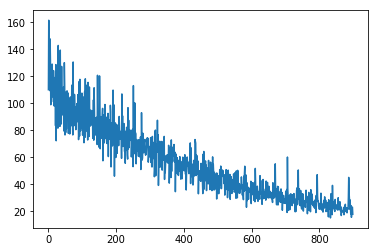

[110.07462, 161.54561, 117.93207, 139.72617, 109.40031, 147.70137, 131.13268, 98.92771, 125.42523, 101.01407, 106.77289, 129.05862, 116.62911, 104.77397, 106.458466, 124.25252, 115.5475, 98.01916, 104.80032, 117.166016, 119.18422, 83.41682, 128.68199, 72.24267, 114.94594, 87.68051, 98.67698, 113.71978, 81.60204, 142.87119, 93.296585, 119.98569, 93.33039, 119.36511, 82.919785, 139.40448, 102.136314, 101.36266, 84.66713, 127.31614, 96.71986, 103.24164, 101.62049, 95.661415, 91.01312, 112.29405, 79.43339, 130.10623, 114.65978, 76.53104, 108.24987, 78.29704, 106.546196, 81.03192, 91.05619, 109.21216, 91.61465, 107.803795, 107.094925, 77.70952, 95.51498, 95.54441, 103.60028, 77.25259, 90.17917, 104.70095, 94.48449, 101.74158, 83.42015, 113.43296, 99.43712, 85.41394, 76.538666, 130.61087, 86.726204, 106.5455, 83.43552, 106.55038, 95.556, 85.79598, 97.04052, 80.45912, 92.19535, 95.53748, 99.77129, 88.56044, 86.38719, 106.43723, 99.562454, 73.08625, 77.76941, 116.25494, 75.712234, 117.75647, 9

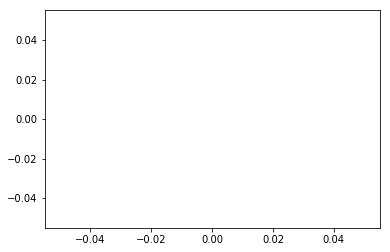

In [23]:
plt.plot(range(len(history.losses)),history.losses) 
plt.show()
print(history.losses)
plt.plot(range(len(history.val_losses)),history.val_losses) 

In [ ]:
predicted = lstm.predict_sequences_multiple(model, X_test, seq_len, 50)
predicted_train = lstm.predict_sequences_multiple(model, X_train, seq_len, 50)
plot_results(predicted_train[:50], y_train[:50], False)
plot_results(np.concatenate([predicted_train,predicted]), np.concatenate([y_train,y_test]), True)
plot_results_multiple(predicted[:50], y_test[:50], 50, False)

In [ ]:
predicted = lstm.predict_sequence_full(model, X_test, seq_len)
predicted_train = lstm.predict_sequence_full(model, X_train, seq_len)